## Installing the Transformers Module.

In [ ]:
!pip install --upgrade transformers

     |████████████████████████████████| 4.0 MB 26.9 MB/s 
     |████████████████████████████████| 895 kB 51.3 MB/s 
     |████████████████████████████████| 596 kB 49.9 MB/s 
     |████████████████████████████████| 6.6 MB 51.3 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Install PyTorch, initiate GPU, and other ML Dependencies

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Downloading the Finanica Sentinment Analysis Dataset.

In [ ]:
financial_data = pd.read_csv("./data.csv")

In [ ]:
financial_data.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


In [ ]:
financial_data.shape

(5842, 2)

## Tokenizer

The tokenizer class `GPT2Tokenizer` inherits properties from the superclass `PreTrainedTokenizer`, which inherits from [`PreTrainedTokenizerBase`](https://huggingface.co/docs/transformers/v4.17.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase). You can look up the class propeties in the links below:

`GPT2Tokenizer` Documentation: https://huggingface.co/docs/transformers/model_doc/gpt2

`PreTrainedTokenizer`: https://huggingface.co/docs/transformers/v4.17.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizer

*****Note**: You can also use the `AutoTokenizer` class, which will instantiate an instance of the same tokenizer class. Found at https://huggingface.co/docs/transformers/v4.17.0/en/model_doc/auto#transformers.AutoTokenizer

In [ ]:
from transformers import GPT2TokenizerFast

gpt_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2", do_lower_case=True)

Since GPT-2 doesn't utilize a padding token during pre-training. We can define one ourselves. However, the model wouldn't recognize this and you would need to train GPT-2 again to account for this. Therefore, we will just use the existing EOS token as padding.

(FYI: you can add new tokens by modifiying the class parameters in https://huggingface.co/docs/transformers/v4.17.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizer. It should be under the first set of parameters listed.)

Our way of doing it: `eos_token`. You can also access the `add_special_tokens` parameter, which digs into the `add_special_tokens` call parameter and adds the new token.

In [ ]:
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

In [ ]:
example_tokenization = financial_data['Sentence'][0]

print("Train data size ", len(example_tokenization))
print('* Original:  ', example_tokenization)
# Print the sentence split into tokens.
print('* Tokenized: ', gpt_tokenizer.tokenize(example_tokenization))
# Print the sentence mapped to token ids.
print('* Token IDs: ', gpt_tokenizer.convert_tokens_to_ids(gpt_tokenizer.tokenize(example_tokenization)))

Train data size  218
* Original:   The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .
* Tokenized:  ['The', 'ĠGeo', 'S', 'olutions', 'Ġtechnology', 'Ġwill', 'Ġleverage', 'ĠBenef', 'on', "Ġ'", 's', 'ĠGPS', 'Ġsolutions', 'Ġby', 'Ġproviding', 'ĠLocation', 'ĠBased', 'ĠSearch', 'ĠTechnology', 'Ġ,', 'Ġa', 'ĠCommunities', 'ĠPlatform', 'Ġ,', 'Ġlocation', 'Ġrelevant', 'Ġmultimedia', 'Ġcontent', 'Ġand', 'Ġa', 'Ġnew', 'Ġand', 'Ġpowerful', 'Ġcommercial', 'Ġmodel', 'Ġ.']
* Token IDs:  [464, 32960, 50, 14191, 3037, 481, 16094, 19899, 261, 705, 82, 15472, 8136, 416, 4955, 13397, 13403, 11140, 8987, 837, 257, 35530, 19193, 837, 4067, 5981, 40162, 2695, 290, 257, 649, 290, 3665, 5068, 2746, 764]


In [ ]:
MAX_LEN = 50

In [ ]:
data_input = financial_data['Sentence'].values
label_input = financial_data['Sentiment'].values

We now build the GPT-2 tokenizer with the following setup:

*   default 12 transformer layers.
*   max length set for transformer input.
*   pad to max length.
*   don't return token types.
*   activate truncation.

****The CLS and SEP tokens are added as the EOS token as the beginning of fine-tuning, as they are here. We use the EOS token to avoid re-training the model.*

In [ ]:
gpt_tokenizer.cls_token = gpt_tokenizer.eos_token
gpt_tokenizer.sep_token = gpt_tokenizer.eos_token

In [ ]:
tokenized_data_inputs = gpt_tokenizer(
    data_input.tolist(),          # Input text
    add_special_tokens=True,      # add '<|CLS|>' and '<|SEP|>'
    padding='max_length',         # pad to a length specified by the max_length
    max_length=MAX_LEN,           # truncate all sentences longer than max_length
    truncation=True,              # activate truncation so batched tensors are the same length
    return_tensors='pt',          # return everything we need as PyTorch tensors
)

## Training and Validation Split

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
input_seqs = tokenized_data_inputs['input_ids']
attention_masks = tokenized_data_inputs['attention_mask']

In [ ]:
def train_valid_split(input_ids, attention_masks, labels):
    # Use 70% for training and 30% for validation and testing.
    train_seq, eval_seq, train_masks, eval_masks, train_labels, eval_labels = train_test_split(
        input_ids, attention_masks, labels, random_state=2018, test_size=0.3, stratify=labels, shuffle=True
    )

    val_seq, test_seq, val_masks, test_masks, val_labels, test_labels = train_test_split(
        eval_seq, eval_masks, eval_labels, random_state=2018, test_size=0.5, stratify=eval_labels, shuffle=True
    )

    return train_seq, train_masks, train_labels, val_seq, val_masks, val_labels, test_seq, test_masks, test_labels


In [ ]:
train_seq, train_masks, train_labels, val_seq, val_masks, val_labels, test_seq, test_masks, test_labels = train_valid_split(input_seqs, attention_masks, label_input)

Change the sentinment into numerical representation. This version of CE Loss will use class indices instead of probabilities. You can check out the class indice and the probabilistic on-hot versions at 
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [ ]:
train_labels[train_labels == 'neutral'] = 0
train_labels[train_labels == 'positive'] = 1
train_labels[train_labels == 'negative'] = 2

val_labels[val_labels == 'neutral'] = 0
val_labels[val_labels == 'positive'] = 1
val_labels[val_labels == 'negative'] = 2

test_labels[test_labels == 'neutral'] = 0
test_labels[test_labels == 'positive'] = 1
test_labels[test_labels == 'negative'] = 2

In [ ]:
train_labels = torch.from_numpy(train_labels.astype('int64'))
val_labels = torch.from_numpy(val_labels.astype('int64'))
test_labels = torch.from_numpy(test_labels.astype('int64'))

We now want to define a Dataloader to load our training and validation data.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
batch_size = 64

train_data = TensorDataset(train_seq, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Adjust Class Weights for Imbalanced Training Dataset.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = np.array(train_labels))

In [ ]:
# convert class weights to tensor
weights = torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

## Setting Up GPT-2 Model for SequenceClassification

We are going to be using the `from_pretrained` module for this task. `GPT2Config` module is used to set the number of labels in the built-in classification head to be 3.

We can find the model documentation here: https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2ForSequenceClassification

If you want to use the `from_pretrained` module: https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/model#transformers.PreTrainedModel.from_pretrained

 ****If you want to use the GPT2ForSequenceClassification module directly like we did before, that's ok too and it's possible to config it as such. It will yield the same result.*

In [ ]:
from transformers import GPT2ForSequenceClassification, GPT2Config

# Initializing a GPT2 configuration
configuration = GPT2Config(num_labels=3)

# Initializing a model from the configuration
gpt2Model = GPT2ForSequenceClassification.from_pretrained("gpt2", config=configuration)
gpt2Model.config.num_labels = 3
gpt2Model.config.pad_token_id = gpt2Model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class GPTForSentinmentClassification(nn.Module):
    def __init__(self, gpt_model):
        super().__init__()
        
        self.gpt = gpt_model

        self.loss = torch.nn.CrossEntropyLoss(weight=weights)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.gpt(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        if labels is not None:
            outputs = (logits, self.loss(logits, labels))
        else:
            outputs = (logits,)
        return outputs

In [ ]:
gpt2_model = GPTForSentinmentClassification(gpt2Model)

In [ ]:
# Model parameters visualization
params = list(gpt2_model.named_parameters())

print('GPT-2 has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== 1st Transformer Layer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== 2nd Transformer Layer ====\n')

for p in params[14:26]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== 3rd Transformer Layer ====\n')

for p in params[26:38]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-5:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

GPT-2 has 149 different named parameters.

==== Embedding Layer ====

gpt.transformer.wte.weight                              (50257, 768)
gpt.transformer.wpe.weight                               (1024, 768)

==== 1st Transformer Layer ====

gpt.transformer.h.0.ln_1.weight                               (768,)
gpt.transformer.h.0.ln_1.bias                                 (768,)
gpt.transformer.h.0.attn.c_attn.weight                   (768, 2304)
gpt.transformer.h.0.attn.c_attn.bias                         (2304,)
gpt.transformer.h.0.attn.c_proj.weight                    (768, 768)
gpt.transformer.h.0.attn.c_proj.bias                          (768,)
gpt.transformer.h.0.ln_2.weight                               (768,)
gpt.transformer.h.0.ln_2.bias                                 (768,)
gpt.transformer.h.0.mlp.c_fc.weight                      (768, 3072)
gpt.transformer.h.0.mlp.c_fc.bias                            (3072,)
gpt.transformer.h.0.mlp.c_proj.weight                    (3072, 768)

## Freeze the Transformer Layer(s):

In [ ]:
for name, param in gpt2_model.named_parameters():
  if 'gpt.transformer.h.0.' in name or 'gpt.transformer.h.1.' in name\
     or 'gpt.transformer.h.2.' in name or 'gpt.transformer.h.3.' in name\
     or 'gpt.transformer.h.4.' in name or 'gpt.transformer.h.5.' in name\
     or 'gpt.transformer.h.6.' in name or 'gpt.transformer.h.7.' in name\
     or 'gpt.transformer.h.8.' in name or 'gpt.transformer.h.9.' in name:
    print(name)
    param.requires_grad = False

gpt.transformer.h.0.ln_1.weight
gpt.transformer.h.0.ln_1.bias
gpt.transformer.h.0.attn.c_attn.weight
gpt.transformer.h.0.attn.c_attn.bias
gpt.transformer.h.0.attn.c_proj.weight
gpt.transformer.h.0.attn.c_proj.bias
gpt.transformer.h.0.ln_2.weight
gpt.transformer.h.0.ln_2.bias
gpt.transformer.h.0.mlp.c_fc.weight
gpt.transformer.h.0.mlp.c_fc.bias
gpt.transformer.h.0.mlp.c_proj.weight
gpt.transformer.h.0.mlp.c_proj.bias
gpt.transformer.h.1.ln_1.weight
gpt.transformer.h.1.ln_1.bias
gpt.transformer.h.1.attn.c_attn.weight
gpt.transformer.h.1.attn.c_attn.bias
gpt.transformer.h.1.attn.c_proj.weight
gpt.transformer.h.1.attn.c_proj.bias
gpt.transformer.h.1.ln_2.weight
gpt.transformer.h.1.ln_2.bias
gpt.transformer.h.1.mlp.c_fc.weight
gpt.transformer.h.1.mlp.c_fc.bias
gpt.transformer.h.1.mlp.c_proj.weight
gpt.transformer.h.1.mlp.c_proj.bias
gpt.transformer.h.2.ln_1.weight
gpt.transformer.h.2.ln_1.bias
gpt.transformer.h.2.attn.c_attn.weight
gpt.transformer.h.2.attn.c_attn.bias
gpt.transformer.h.2.at

Mount the model onto device.

In [ ]:
# Use GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt2_model = gpt2_model.to(device)

## Training the Model


*   Batch Size
*   Learning Rate
*   Weight Decay

We can find more hyperparameters to tune with Config: https://huggingface.co/docs/transformers/model_doc/gpt2

Here, we needed to use some of the code from the assignment.


In [ ]:
from torch.optim import AdamW
import time
import datetime
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def get_optimizer_and_scheduler(model, total_steps, lr=2e-5, weight_decay=0.01):
    # Apply weight decay to all parameters beside the biases
    no_decay = ['bias']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': weight_decay},
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        # Warmup learning rate for first 10% of training steps
        num_warmup_steps=int(0.10 * total_steps), 
        num_training_steps=total_steps,
    )
    return optimizer, scheduler

In [ ]:
def train_model(model, epochs, train_dataloader, validation_dataloader):

    # Set learning rate and weight decay:
    lr = 0.001
    weight_decay = 0.01

    # Setup optimizer and LR scheduler.
    total_steps = len(train_dataloader) * epochs
    optimizer, scheduler = get_optimizer_and_scheduler(
        model, total_steps, lr=lr, weight_decay=weight_decay
    )

    loss_values = []
    train_acc_values = []

    eval_loss_vals = []
    eval_accs = []

    for epoch in range(0, epochs):
        t0 = time.time()

        total_loss = 0
        total_train_accuracy = 0

        # Initiate training mode.
        model.train()

        with tqdm(train_dataloader, unit="batch") as train_pbar:

            # Training with each batch in the training set:
            for batch in train_pbar:
                train_pbar.set_description(f"Training (epoch {epoch + 1})")

                # Splitting the training batch into it's respective parts:
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Clear previously calculated gradients:
                model.zero_grad()        

                # Get model predictions and loss:
                outputs = model(
                    input_ids=b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels
                )
                
                train_logits, loss = outputs

                # Move the training logits and training labels to CPU
                train_logits = train_logits.detach().cpu().numpy()
                label_ids_train = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of training sentences.
                tmp_train_accuracy = flat_accuracy(train_logits, label_ids_train)

                # Accumulate total training accuracy.
                total_train_accuracy += tmp_train_accuracy

                total_loss += loss.item()

                # Backprop.
                loss.backward()

                # Clip the the gradients to 1.0. It helps in preventing the exploding gradient problem.
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters.
                optimizer.step()

                scheduler.step()

        # Calculate the average loss and accuracy over the training data.
        avg_train_loss = total_loss / len(train_dataloader)    
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)  
        
        # Store the loss and accuracy values for plotting the learning curve.
        loss_values.append(avg_train_loss)
        train_acc_values.append(avg_train_accuracy)

        print("  * Average training loss: {0:.2f}".format(avg_train_loss))
        print("  * Average training accuracy: {0:.2f}".format(avg_train_accuracy))
        print("  * Training epoch took: {:}".format(format_time(time.time() - t0)))
            
        print("Running Validation...")

        t0 = time.time()
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                outputs = model(
                    input_ids=b_input_ids, 
                    attention_mask=b_input_mask,
                    labels=b_labels
                )

            v_loss = outputs[1]
            eval_loss += v_loss.item()

            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits = outputs[0]
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
            # Track the number of batches
            nb_eval_steps += 1

        avg_eval_loss = eval_loss/nb_eval_steps
        avg_eval_acc = eval_accuracy/nb_eval_steps

        print("  * Loss: {0:.2f}".format(avg_eval_loss))
        print("  * Accuracy: {0:.2f}".format(avg_eval_acc))
        print("  * Validation took: {:}".format(format_time(time.time() - t0)))

        eval_loss_vals.append(avg_eval_loss)
        eval_accs.append(avg_eval_acc)
    print("Training complete!")
    return loss_values, train_acc_values, eval_loss_vals, eval_accs

In [ ]:
gpt2_train_loss_vals, gpt2_train_accs, gpt2_eval_loss_vals, gpt2_eval_accs = train_model(
    model=gpt2_model,
    epochs=40, 
    train_dataloader=train_dataloader,
    validation_dataloader=val_dataloader
)

Training (epoch 1): 100%|██████████| 64/64 [00:27<00:00,  2.35batch/s]


  * Average training loss: 2.46
  * Average training accuracy: 0.42
  * Training epoch took: 0:00:27
Running Validation...
  * Loss: 0.93
  * Accuracy: 0.58
  * Validation took: 0:00:03


Training (epoch 2): 100%|██████████| 64/64 [00:28<00:00,  2.28batch/s]


  * Average training loss: 0.73
  * Average training accuracy: 0.68
  * Training epoch took: 0:00:28
Running Validation...
  * Loss: 0.54
  * Accuracy: 0.77
  * Validation took: 0:00:03


Training (epoch 3): 100%|██████████| 64/64 [00:28<00:00,  2.24batch/s]


  * Average training loss: 0.46
  * Average training accuracy: 0.80
  * Training epoch took: 0:00:29
Running Validation...
  * Loss: 0.62
  * Accuracy: 0.74
  * Validation took: 0:00:03


Training (epoch 4): 100%|██████████| 64/64 [00:29<00:00,  2.20batch/s]


  * Average training loss: 0.36
  * Average training accuracy: 0.84
  * Training epoch took: 0:00:29
Running Validation...
  * Loss: 0.76
  * Accuracy: 0.70
  * Validation took: 0:00:03


Training (epoch 5): 100%|██████████| 64/64 [00:29<00:00,  2.17batch/s]


  * Average training loss: 0.29
  * Average training accuracy: 0.86
  * Training epoch took: 0:00:29
Running Validation...
  * Loss: 0.71
  * Accuracy: 0.76
  * Validation took: 0:00:03


Training (epoch 6): 100%|██████████| 64/64 [00:30<00:00,  2.13batch/s]


  * Average training loss: 0.25
  * Average training accuracy: 0.88
  * Training epoch took: 0:00:30
Running Validation...
  * Loss: 0.82
  * Accuracy: 0.76
  * Validation took: 0:00:03


Training (epoch 7): 100%|██████████| 64/64 [00:30<00:00,  2.09batch/s]


  * Average training loss: 0.20
  * Average training accuracy: 0.89
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 0.79
  * Accuracy: 0.76
  * Validation took: 0:00:03


Training (epoch 8): 100%|██████████| 64/64 [00:31<00:00,  2.05batch/s]


  * Average training loss: 0.18
  * Average training accuracy: 0.91
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 0.96
  * Accuracy: 0.72
  * Validation took: 0:00:03


Training (epoch 9): 100%|██████████| 64/64 [00:31<00:00,  2.05batch/s]


  * Average training loss: 0.17
  * Average training accuracy: 0.91
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 1.28
  * Accuracy: 0.76
  * Validation took: 0:00:03


Training (epoch 10): 100%|██████████| 64/64 [00:30<00:00,  2.06batch/s]


  * Average training loss: 0.16
  * Average training accuracy: 0.91
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 1.28
  * Accuracy: 0.75
  * Validation took: 0:00:03


Training (epoch 11): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.14
  * Average training accuracy: 0.92
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 1.63
  * Accuracy: 0.74
  * Validation took: 0:00:03


Training (epoch 12): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.14
  * Average training accuracy: 0.92
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 1.52
  * Accuracy: 0.76
  * Validation took: 0:00:03


Training (epoch 13): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.13
  * Average training accuracy: 0.92
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.13
  * Accuracy: 0.76
  * Validation took: 0:00:03


Training (epoch 14): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.13
  * Average training accuracy: 0.92
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 1.87
  * Accuracy: 0.74
  * Validation took: 0:00:03


Training (epoch 15): 100%|██████████| 64/64 [00:31<00:00,  2.06batch/s]


  * Average training loss: 0.13
  * Average training accuracy: 0.92
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 1.74
  * Accuracy: 0.76
  * Validation took: 0:00:03


Training (epoch 16): 100%|██████████| 64/64 [00:31<00:00,  2.05batch/s]


  * Average training loss: 0.13
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 1.99
  * Accuracy: 0.75
  * Validation took: 0:00:03


Training (epoch 17): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.12
  * Average training accuracy: 0.92
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 1.57
  * Accuracy: 0.73
  * Validation took: 0:00:03


Training (epoch 18): 100%|██████████| 64/64 [00:31<00:00,  2.06batch/s]


  * Average training loss: 0.12
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 1.93
  * Accuracy: 0.74
  * Validation took: 0:00:03


Training (epoch 19): 100%|██████████| 64/64 [00:31<00:00,  2.05batch/s]


  * Average training loss: 0.12
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 1.92
  * Accuracy: 0.72
  * Validation took: 0:00:03


Training (epoch 20): 100%|██████████| 64/64 [00:31<00:00,  2.05batch/s]


  * Average training loss: 0.11
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.15
  * Accuracy: 0.74
  * Validation took: 0:00:03


Training (epoch 21): 100%|██████████| 64/64 [00:31<00:00,  2.06batch/s]


  * Average training loss: 0.11
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.35
  * Accuracy: 0.71
  * Validation took: 0:00:03


Training (epoch 22): 100%|██████████| 64/64 [00:31<00:00,  2.06batch/s]


  * Average training loss: 0.12
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.42
  * Accuracy: 0.73
  * Validation took: 0:00:03


Training (epoch 23): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.12
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.70
  * Accuracy: 0.73
  * Validation took: 0:00:03


Training (epoch 24): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.11
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.57
  * Accuracy: 0.73
  * Validation took: 0:00:03


Training (epoch 25): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.11
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.31
  * Accuracy: 0.73
  * Validation took: 0:00:03


Training (epoch 26): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.11
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.83
  * Accuracy: 0.73
  * Validation took: 0:00:03


Training (epoch 27): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.11
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.68
  * Accuracy: 0.71
  * Validation took: 0:00:03


Training (epoch 28): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.11
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.55
  * Accuracy: 0.72
  * Validation took: 0:00:03


Training (epoch 29): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.69
  * Accuracy: 0.73
  * Validation took: 0:00:03


Training (epoch 30): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.94
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.91
  * Accuracy: 0.72
  * Validation took: 0:00:03


Training (epoch 31): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.96
  * Accuracy: 0.72
  * Validation took: 0:00:03


Training (epoch 32): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.94
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.85
  * Accuracy: 0.72
  * Validation took: 0:00:03


Training (epoch 33): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.94
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 3.00
  * Accuracy: 0.71
  * Validation took: 0:00:03


Training (epoch 34): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.93
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.80
  * Accuracy: 0.71
  * Validation took: 0:00:03


Training (epoch 35): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.94
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 2.96
  * Accuracy: 0.72
  * Validation took: 0:00:03


Training (epoch 36): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.94
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 3.19
  * Accuracy: 0.72
  * Validation took: 0:00:03


Training (epoch 37): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.94
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 3.11
  * Accuracy: 0.71
  * Validation took: 0:00:03


Training (epoch 38): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.94
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 3.15
  * Accuracy: 0.71
  * Validation took: 0:00:03


Training (epoch 39): 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.94
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 3.27
  * Accuracy: 0.71
  * Validation took: 0:00:03


Training (epoch 40): 100%|██████████| 64/64 [00:31<00:00,  2.05batch/s]


  * Average training loss: 0.10
  * Average training accuracy: 0.94
  * Training epoch took: 0:00:31
Running Validation...
  * Loss: 3.28
  * Accuracy: 0.71
  * Validation took: 0:00:03
Training complete!


## Storing the Results

In [ ]:
import json

In [ ]:
with open('frozen_losses_gpt.json') as json_file:
    loss_dict = json.load(json_file)

In [ ]:
loss_dict.keys()

dict_keys(['frozen_1_2', 'frozen_1_4', 'frozen_1_6', 'frozen_1_8', 'frozen_1_10'])

In [ ]:
loss_dict['frozen_1_10'] = {}

In [ ]:
loss_dict['frozen_1_10']['training_loss'] = gpt2_train_loss_vals
loss_dict['frozen_1_10']['val_loss'] = gpt2_eval_loss_vals

In [ ]:
loss_dict.keys()

dict_keys(['frozen_1_2', 'frozen_1_4', 'frozen_1_6', 'frozen_1_8', 'frozen_1_10'])

In [ ]:
with open("frozen_losses_gpt.json", "w") as outfile:
    json.dump(loss_dict, outfile)
    
outfile.close()

In [ ]:
with open('frozen_accs_gpt.json') as json_file:
    acc_dict = json.load(json_file)

In [ ]:
acc_dict.keys()

dict_keys(['frozen_1_2', 'frozen_1_4', 'frozen_1_6', 'frozen_1_8', 'frozen_1_10'])

In [ ]:
acc_dict['frozen_1_10'] = {}

In [ ]:
acc_dict['frozen_1_10']['training_acc'] = gpt2_train_accs
acc_dict['frozen_1_10']['val_acc'] = gpt2_eval_accs

In [ ]:
acc_dict.keys()

dict_keys(['frozen_1_2', 'frozen_1_4', 'frozen_1_6', 'frozen_1_8', 'frozen_1_10'])

In [ ]:
with open("frozen_accs_gpt.json", "w") as outfile:
    json.dump(acc_dict, outfile)
    
outfile.close()

## Get Predictions for Test Data

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = gpt2_model(input_ids=test_seq.to(device), attention_mask=test_masks.to(device))
  preds = preds[0].detach().cpu().numpy()

In [ ]:
def test_flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1)
    labels_flat = np.array(labels.flatten())
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
test_flat_accuracy(preds, test_labels)

0.7468643101482326

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       470
           1       0.85      0.86      0.86       278
           2       0.39      0.50      0.44       129

    accuracy                           0.75       877
   macro avg       0.68      0.70      0.69       877
weighted avg       0.76      0.75      0.75       877



In [ ]:
# confusion matrix
pd.crosstab(test_labels, preds)

col_0,0,1,2
row_0,,,
0,354,27,89
1,21,245,12
2,52,11,66


## Training and Validation Loss Graphs

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss(eval_l_1, eval_l_2, eval_l_3, eval_l_4, eval_l_5):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    plt.title('GPT-2 Validation Loss by Frozen Layers') 
    ax1.plot(np.arange(1, len(eval_l_1)+1), eval_l_1, 'b-o', label = 'Layers 1-2')
    ax1.plot(np.arange(1, len(eval_l_1)+1), eval_l_2, 'g-o', label = 'Layers 1-4')
    ax1.plot(np.arange(1, len(eval_l_1)+1), eval_l_3, 'r-o', label = 'Layers 1-6')
    ax1.plot(np.arange(1, len(eval_l_1)+1), eval_l_4, 'c-o', label = 'Layers 1-8')
    ax1.plot(np.arange(1, len(eval_l_1)+1), eval_l_5, 'y-o', label = 'Layers 1-10')
    ax1.set_xlabel("Epochs", color='k')
    ax1.set_ylabel("Loss", color='k')
    ax1.tick_params(axis='y', rotation=0, labelcolor='k' )
    plt.legend()
    plt.show()

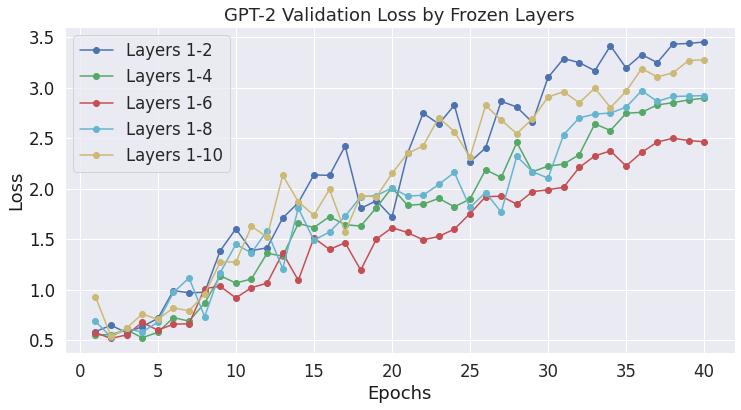

In [ ]:
plot_loss(loss_dict['frozen_1_2']['val_loss'], loss_dict['frozen_1_4']['val_loss'], loss_dict['frozen_1_6']['val_loss'], loss_dict['frozen_1_8']['val_loss'], loss_dict['frozen_1_10']['val_loss'])

## Training and Validation Accuracy Graphs

In [ ]:
def plot_acc(eval_l_1, eval_l_2, eval_l_3, eval_l_4, eval_l_5):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    plt.title('GPT-2 Validation Accuracy by Frozen Layers') 
    ax1.plot(np.arange(1, len(eval_l_1)+1), eval_l_1, 'b-o', label = 'Layers 1-2')
    ax1.plot(np.arange(1, len(eval_l_1)+1), eval_l_2, 'g-o', label = 'Layers 1-4')
    ax1.plot(np.arange(1, len(eval_l_1)+1), eval_l_3, 'r-o', label = 'Layers 1-6')
    ax1.plot(np.arange(1, len(eval_l_1)+1), eval_l_4, 'c-o', label = 'Layers 1-8')
    ax1.plot(np.arange(1, len(eval_l_1)+1), eval_l_5, 'y-o', label = 'Layers 1-10')
    ax1.set_xlabel("Epochs", color='k')
    ax1.set_ylabel("Accuracy", color='k')
    ax1.tick_params(axis='y', rotation=0, labelcolor='k' )
    plt.legend()
    plt.show()

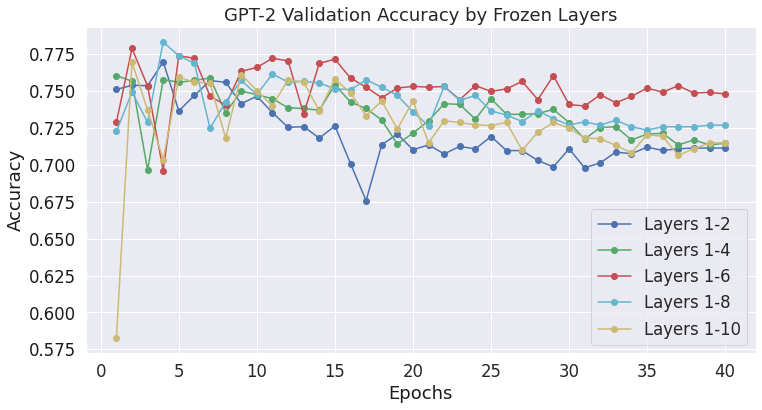

In [ ]:
plot_acc(acc_dict['frozen_1_2']['val_acc'], acc_dict['frozen_1_4']['val_acc'], acc_dict['frozen_1_6']['val_acc'], acc_dict['frozen_1_8']['val_acc'], acc_dict['frozen_1_10']['val_acc'])